In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mkdir dataset
# !mkdir dataset
# !unzip drive/MyDrive/mapaton2022/TrainData.zip
# !unzip drive/MyDrive/mapaton2022/ValidData.zip
# !unzip drive/MyDrive/mapaton2022/TestData.zip
!cp drive/MyDrive/mapaton2022/dataset/train.txt train.txt
!cp drive/MyDrive/mapaton2022/dataset/valid.txt valid.txt
!cp drive/MyDrive/mapaton2022/dataset/test.txt test.txt
!cp drive/MyDrive/mapaton2022/model/Networks.py Networks.py
# !cp exp/batch4500_F1_7434.pth drive/MyDrive/mapaton2022/exp/batch4500_F1_7434.pth

## Leer dataset

In [1]:
import numpy as np
import pandas as pd
import requests
import re
import os
import h5py

In [2]:
path_img = r'TrainData/img/image_35.h5'
mask_img = r'TrainData/mask/mask_35.h5'

with h5py.File(path_img, 'r') as hf_img:
    image = hf_img['img'][:]

with h5py.File(mask_img, 'r') as hf_mask:
    label = hf_mask['mask'][:]

In [46]:
import rasterio

path_img = r'NewData/0001.tif'

data = rasterio.open(path_img).read()
image = data.transpose((-1, 1, 0))

In [49]:
import numpy as np
image = np.asarray(image, np.float32)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <a list of 128 BarContainer objects>)

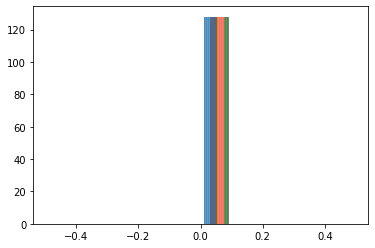

In [59]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
image_n = image/np.linalg.norm(image)
plt.hist(image_n[...,3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


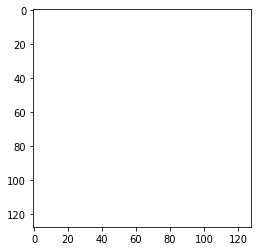

In [58]:
import matplotlib.pyplot as plt
plt.imshow(image[:,:,[4,3,1]])

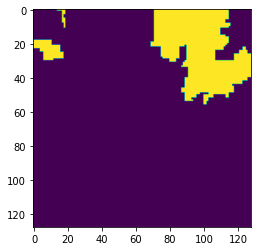

In [6]:
plt.imshow(label)

## Dataloader

In [7]:
# Read train data
data_dir = r""
list_path = r"dataset/train.txt"
max_iters = None
set = 'labeled'
img_ids = [i_id.strip() for i_id in open(list_path)]

if not max_iters == None:
    n_repeat = int(np.ceil(max_iters / len(img_ids)))
    img_ids = img_ids * n_repeat + img_ids[:max_iters-n_repeat*len(img_ids)]

files = []

if set == 'labeled':
    for name in img_ids:
        img_file = data_dir + name
        label_file = data_dir + name.replace('img','mask').replace('image','mask')
        files.append({
            'img': img_file,
            'label': label_file
        })
elif set == 'unlabeled':
    for name in img_ids:
        img_file = data_dir + name
        files.append({
            'img': img_file
        })

In [8]:
data = pd.DataFrame(files)
data.head()

,img,label
0,TrainData/img/image_1.h5,TrainData/mask/mask_1.h5
1,TrainData/img/image_2.h5,TrainData/mask/mask_2.h5
2,TrainData/img/image_3.h5,TrainData/mask/mask_3.h5
3,TrainData/img/image_4.h5,TrainData/mask/mask_4.h5
4,TrainData/img/image_5.h5,TrainData/mask/mask_5.h5


In [9]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [10]:
import tensorflow as tf
import tensorflow.keras as keras

In [40]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import h5py

from skimage import exposure

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
CHANNELS = 14

BATCH_SIZE = 10

class CustomDataGen(keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(IMG_WIDTH, IMG_HEIGHT, CHANNELS),
                 shuffle=True):
        ################
        self.mean = [-0.4914, -0.3074, -0.1277, -0.0625, 0.0439, 0.0803, 0.0644, 0.0802, 0.3000, 0.4082, 0.0823, 0.0516, 0.3338, 0.7819]
        self.std = [0.9325, 0.8775, 0.8860, 0.8869, 0.8857, 0.8418, 0.8354, 0.8491, 0.9061, 1.6072, 0.8848, 0.9232, 0.9018, 1.2913]
        ################
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle

        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        with h5py.File(path, 'r') as hf_img:
            image_arr = hf_img['img'][:]
        
        image = np.asarray(image_arr, np.float32)
        # image = image.transpose((-1, 0, 1))
        
        for i in range(len(self.mean)):
                image[:,:,i] -= self.mean[i]
                image[:,:,i] /= self.std[i]
        return image
    
    def __get_output(self, path):
        with h5py.File(path, 'r') as hf_lab:
            image_arr = hf_lab['mask'][:]
        label = np.asarray(image_arr, np.float32)
        return label
    
    def __get_data(self, batches):
        batches_x = batches[self.X_col]
        batches_y = batches[self.y_col]

        X_batch = np.asarray([self.__get_input(x) for x in batches_x])
        y_batch = np.asarray([self.__get_output(y) for y in batches_y])
        
        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [41]:
train_loader = CustomDataGen(train_data,
                            X_col="img",
                            y_col="label",
                            batch_size=BATCH_SIZE, input_size=IMG_SIZE)

### Modelo

In [13]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.utils import plot_model

In [14]:
# def down_block(x, filters, kernel_size=(3, 3), padding=1, strides=1):
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
#     return c, p

# def up_block(x, skip, filters, kernel_size=(3, 3), padding=1, strides=1):
#     us = keras.layers.UpSampling2D((2, 2))(x)
#     concat = keras.layers.Concatenate()([us, skip])
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     return c

# def bottleneck(x, filters, kernel_size=(3, 3), padding=1, strides=1):
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     return c

# def UNet():
#     inputs = keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_SIZE))
    
#     p0 = inputs
#     c1, p1 = down_block(p0, 64) #512 -> 64
#     c2, p2 = down_block(p1, 128) #64 -> 128
#     c3, p3 = down_block(p2, 256) #128 -> 256
#     c4, p4 = down_block(p3, 512) #256->512
    
#     bn = bottleneck(p4, 1024)
    
#     u1 = up_block(bn, c4, 512) #1024 -> 512
#     u2 = up_block(u1, c3, 256) #512 -> 256
#     u3 = up_block(u2, c2, 128) #256 -> 128
#     u4 = up_block(u3, c1, 64) #128 -> 64
    
#     outputs = Conv2D(1, (1, 1), padding=1, activation="sigmoid")(u4)
#     model = Model(inputs, outputs)
#     return model

In [43]:
image_input = keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, CHANNELS))

# Contracting path
c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(image_input)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
maxp1 = MaxPool2D((2, 2))(c1)

c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(maxp1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
maxp2 = MaxPool2D((2, 2))(c2)

c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(maxp2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
maxp3 = MaxPool2D((2, 2))(c3)

c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(maxp3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
maxp4 = MaxPool2D((2, 2))(c4)

c5 = Conv2D(1024, (3, 3), activation="relu", padding="same")(maxp4)
c5 = Dropout(0.2)(c5)
c5 = Conv2D(1024, (3, 3), activation="relu", padding="same")(c5)
maxp5 = MaxPool2D((2, 2))(c5)

# Expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
up6 = concatenate([up6, c4])
c6 = Conv2D(512, (3, 3), activation="relu", padding="same")(up6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(512, (3, 3), activation="relu", padding="same")(c6)

up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
up7 = concatenate([up7, c3])
c7 = Conv2D(256, (3, 3), activation="relu", padding="same")(up7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(256, (3, 3), activation="relu", padding="same")(c7)

up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
up8 = concatenate([up8, c2])
c8 = Conv2D(128, (3, 3), activation="relu", padding="same")(up8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(128, (3, 3), activation="relu", padding="same")(c8)

up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
up9 = concatenate([up9, c1])
c9 = Conv2D(64, (3, 3), activation="relu", padding="same")(up9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(64, (3, 3), activation="relu", padding="same")(c9)

outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

model = Model(inputs=[image_input], outputs=[outputs])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                4)]                                                               
                                                                                                  
 conv2d_54 (Conv2D)             (None, 128, 128, 64  8128        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 64  0           ['conv2d_54[0][0]']              
                                )                                                           

Tensorboard

In [44]:
from datetime import datetime
from keras.callbacks import TensorBoard

%load_ext tensorboard
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Entrenando

In [45]:
train_loader = CustomDataGen(train_data,
                        X_col="img",
                        y_col="label",
                        batch_size=BATCH_SIZE, input_size=IMG_SIZE)

val_loader = CustomDataGen(val_data,
                        X_col="img",
                        y_col="label",
                        batch_size=BATCH_SIZE, input_size=IMG_SIZE)

In [48]:
# warm-up
results = model.fit(train_loader, 
                    validation_data=val_loader,
                    batch_size=BATCH_SIZE,
                    epochs=2)

Epoch 1/2
303/303 [==============================] - 4859s 16s/step - loss: 0.3588 - accuracy: 0.9767 - val_loss: 0.3530 - val_accuracy: 0.9771
Epoch 2/2
303/303 [==============================] - 5355s 18s/step - loss: 0.3592 - accuracy: 0.9767 - val_loss: 0.3530 - val_accuracy: 0.9771


In [16]:
import numpy as np

def eval_image(predict,label,num_classes):
    index = np.where((label>=0) & (label<num_classes))
    predict = predict[index]
    label = label[index] 
    
    TP = np.zeros((num_classes, 1))
    FP = np.zeros((num_classes, 1))
    TN = np.zeros((num_classes, 1))
    FN = np.zeros((num_classes, 1))
    
    for i in range(0,num_classes):
        TP[i] = np.sum(label[np.where(predict==i)]==i)
        FP[i] = np.sum(label[np.where(predict==i)]!=i)
        TN[i] = np.sum(label[np.where(predict!=i)]!=i)
        FN[i] = np.sum(label[np.where(predict!=i)]==i)        
    
    return TP,FP,TN,FN,len(label)

## Predict

In [ ]:
import argparse
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils import data
import torch.backends.cudnn as cudnn
import h5py

name_classes = ['Non-Landslide','Landslide']
epsilon = 1e-14

def importName(modulename, name):
    """ Import a named object from a module in the context of this function.
    """
    try:
        module = __import__(modulename, globals(), locals(  ), [name])
    except ImportError:
        return None
    return vars(module)[name]


In [ ]:
!mv img/ TestData/

In [ ]:
data_dir = ''
model_module ='Networks'
model_name ='unet'
test_list ='test.txt'
input_s ='128,128'
num_classes = 2
num_workers = 0
gpu_id = 0
snapshot_dir = 'test_map/'
restore_from ='exp/batch5000_F1_7441.pth'

def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    if os.path.exists(snapshot_dir)==False:
        os.makedirs(snapshot_dir)

    w, h = map(int, input_s.split(','))
    input_size = (w, h)

    cudnn.enabled = True
    cudnn.benchmark = True
    
    # Create network   
    model = unet(n_classes=num_classes)
   
    saved_state_dict = torch.load(restore_from)  
    model.load_state_dict(saved_state_dict)

    model = model.cuda()

    test_loader = data.DataLoader(
                    LandslideDataSet(data_dir, test_list, set='unlabeled'),
                    batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=True)


    interp = nn.Upsample(size=(input_size[1], input_size[0]), mode='bilinear')
    

    print('Testing..........')
    model.eval()
   

    for index, batch in enumerate(test_loader):  
        image, _, name = batch
        image = image.float().cuda()
        name = name[0].split('.')[0].split('/')[-1].replace('image','mask')
        print(index+1, '/', len(test_loader), ': Testing ', name)  
        
        with torch.no_grad():
            pred = model(image)

        _,pred = torch.max(interp(nn.functional.softmax(pred,dim=1)).detach(), 1)
        pred = pred.squeeze().data.cpu().numpy().astype('uint8')         
        with h5py.File(snapshot_dir+name+'.h5','w') as hf:
            hf.create_dataset('mask', data=pred)


In [ ]:
main()

Testing..........
1 / 800 : Testing  mask_1
2 / 800 : Testing  mask_2
3 / 800 : Testing  mask_3
4 / 800 : Testing  mask_4
5 / 800 : Testing  mask_5
6 / 800 : Testing  mask_6
7 / 800 : Testing  mask_7
8 / 800 : Testing  mask_8
9 / 800 : Testing  mask_9
10 / 800 : Testing  mask_10
11 / 800 : Testing  mask_11
12 / 800 : Testing  mask_12
13 / 800 : Testing  mask_13
14 / 800 : Testing  mask_14
15 / 800 : Testing  mask_15
16 / 800 : Testing  mask_16
17 / 800 : Testing  mask_17
18 / 800 : Testing  mask_18
19 / 800 : Testing  mask_19
20 / 800 : Testing  mask_20
21 / 800 : Testing  mask_21
22 / 800 : Testing  mask_22
23 / 800 : Testing  mask_23
24 / 800 : Testing  mask_24
25 / 800 : Testing  mask_25
26 / 800 : Testing  mask_26
27 / 800 : Testing  mask_27
28 / 800 : Testing  mask_28
29 / 800 : Testing  mask_29
30 / 800 : Testing  mask_30
31 / 800 : Testing  mask_31
32 / 800 : Testing  mask_32
33 / 800 : Testing  mask_33
34 / 800 : Testing  mask_34
35 / 800 : Testing  mask_35
36 / 800 : Testing  

In [43]:
path_img = r'TrainData/img/image_11.h5'
mask_img = r'TrainData/mask/mask_11.h5'

with h5py.File(path_img, 'r') as hf_img:
    image = hf_img['img'][:]

with h5py.File(mask_img, 'r') as hf_mask:
    label = hf_mask['mask'][:]

In [47]:
image.shape

(128, 128, 14)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


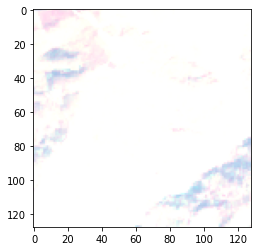

In [44]:
import matplotlib.pyplot as plt
plt.imshow(image[:,:,[4,3,1]])

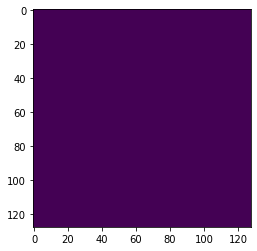

In [45]:
plt.imshow(label)